In [1]:
%matplotlib notebook

import os
import time
import numpy as np
import matplotlib as mpl

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

import qcodes as qc
from qcodes import load_by_id
from qcodes.dataset.measurements import Measurement
from qcodes.instrument.base import Instrument
from qcodes.instrument.parameter import Parameter

from pytopo.qctools.instruments import create_inst
#from pytopo.qctools.dataset2 import select_experiment

from plottr import client
from plottr.qcodes_dataset import QcodesDatasetSubscriber

#from pytopo.mplplots.init_nb_plotting import *


from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin
from scipy.integrate import cumtrapz

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from qcodes.dataset.sqlite_base import transaction, one

def get_timestamp(run_id):
    DB = qc.config["core"]["db_location"]
    
    d = DataSet(DB)
    sql = """
    SELECT run_timestamp
    FROM
      runs
    WHERE
      run_id= ?
    """
    c = transaction(d.conn, sql, run_id)
    run_timestamp = one(c, 'run_timestamp')
    return run_timestamp

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "d:/data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

In [3]:
def smooth(x, window_len=10):
    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    w = np.ones(window_len,'d')
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[int(window_len/2-1):int(-window_len/2)]


def process_data(bias, current, R, smooth_win=50):     #, voltage
    #bias    = bias
    #voltage -= voltage.mean()
    #current -= current[current.size//2]
    bias    -= current * R
    
    bias = bias*1e6
    #voltage = voltage*1e6
    current = current*1e8
    
    iof, bof = find_offset(current, bias, smooth_win=smooth_win)
    #print(iof, bof)
    #bias = bias + bof

    #_, vof = find_offset(current, voltage, smooth_win=smooth_win)
    #voltage -= vof
    # current -= iof
    #print(vof)
    
    
    return bias, current #, voltage


def find_offset(i, v, i_th=0.1, delta=1e-9, max_it=100, smooth_win=50):
    ifunc = interp1d(v, smooth(i, smooth_win), fill_value='extrapolate')
    v_guess = v[np.argmin(abs(i-i_th))] 
    # print(v_guess)
    v_pos = v_guess
    v_neg = -v_guess
    v_of = 0
    i_of = 0
    
    for k in range(max_it):
        #print(k, v_of, i_of)
        
        # for each iteration:
        # 1) using current i/v offsets, find v where i exceeds the threshold (both pos and neg side)
        # 2) update the v-offset by adding the mean of the new found values to the current one
        # 3) update i-offset (just the function value of i at the new 'zero' v value)
        v_pos = fmin(lambda v: abs(ifunc(v+v_of)-i_th-i_of), v_pos, disp=0, xtol=1e-8, ftol=1e-8)
        v_neg = fmin(lambda v: abs(ifunc(v+v_of)+i_th-i_of), v_neg, disp=0, xtol=1e-8, ftol=1e-8)
        v_of_new = (v_pos+v_neg)/2.
        
        if abs(v_of - v_of_new) < delta:
            v_of = v_of_new
            i_of = ifunc(v_of)
            break

        v_of = v_of_new
        i_of = ifunc(v_of)
    
    print(v_pos, v_neg)
    print(i_of, v_of)
    return i_of, v_of
    

def fit_linslope(i, v, ilim=None, vlim=None):  
    if ilim is not None:
        fltr = (i>ilim[0]) & (i<ilim[1])
    elif vlim is not None:
        fltr = (v>vlim[0]) & (v<vlim[1])
    else:
        fltr = slice(None, None, None)
        
    i2 = i[fltr]
    v2 = v[fltr]
    
    plt.figure()
    plt.plot(v2,i2)
    
    p = np.polyfit(np.log(i2[i2>0]), v2[i2>0], 1)
    i_linfit = np.exp((v2-p[1])/p[0])
    T_slope = constants.e * p[0] * 1e-6 / constants.k
    
    return v2, i_linfit, T_slope


def fit_tunnelres(i, v, ilim=None, vlim=None):  
    if ilim is not None:
        fltr = (i>ilim[0]) & (i<ilim[1])
    elif vlim is not None:
        fltr = (v>vlim[0]) & (v<vlim[1])
    else:
        fltr = slice(None, None, None)
        
    i2 = i[fltr]
    v2 = v[fltr]
    
    p = np.polyfit(v2[i2>0], i2[i2>0],  1)
    i_fit = np.polyval(p, v2)
    r_fit = 1./p[0]
    
    return v2, i_fit, r_fit

In [4]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):

    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except (ValueError, msg):
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

<IPython.core.display.Javascript object>


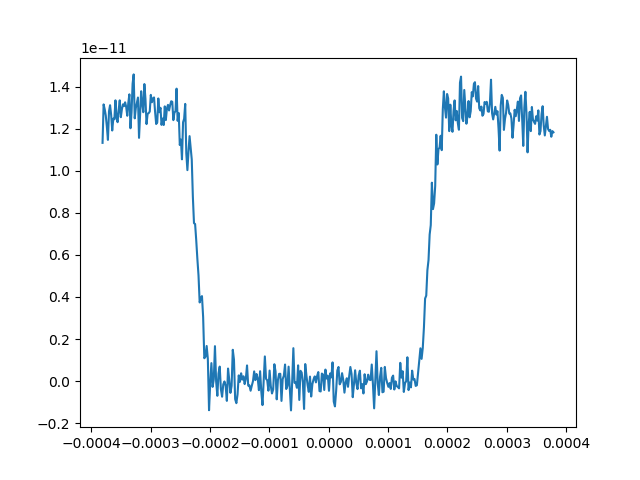

<IPython.core.display.Javascript object>


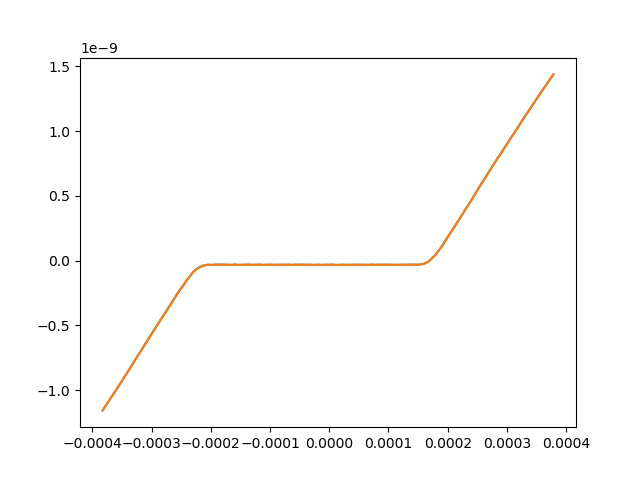

<IPython.core.display.Javascript object>


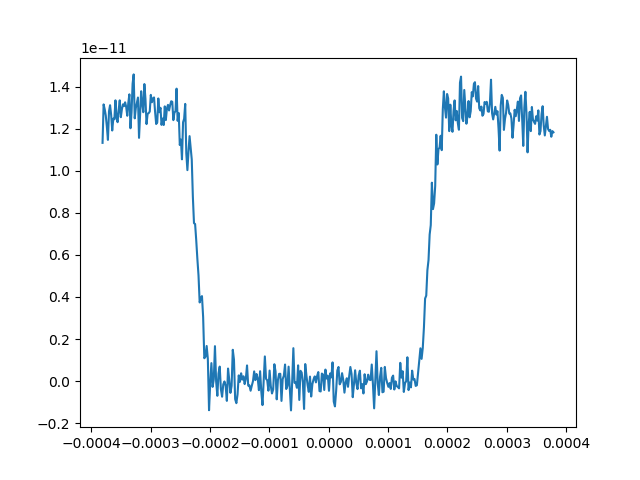

In [520]:
dv = qc.load_by_id(327)

b = np.array(dv.get_data("mdac_voltage"))[:,0]
i = -np.array(dv.get_values('current'))[:,0]

b_p,i_p = process_data(b,i,15e3, smooth_win=11)

plt.figure('mdac_gap')
plt.plot(b[1:],savitzky_golay(i[1:]-i[:-1], 7,5))  # /np.ediff1d(b)) #

plt.figure('mdac_gap_sub')
plt.plot(b,i, b_p, i_p)  # /np.ediff1d(b)) #

plt.figure('mdac_gap_sub derivative')
plt.plot(b_p[1:],savitzky_golay(i[1:]-i[:-1], 7,5))  # /np.ediff1d(b)) #

In [490]:
i_d = np.gradient(smooth(i,11),np.ediff1d(b, to_end=1)) # np.ediff1d(i, to_end=1)/np.ediff1d(b, to_end=1)
#i_d.append(0)
plt.figure()
plt.plot(b,i_d[1:])

ValueError: when 1d, distances must match the length of the corresponding dimension

<IPython.core.display.Javascript object>


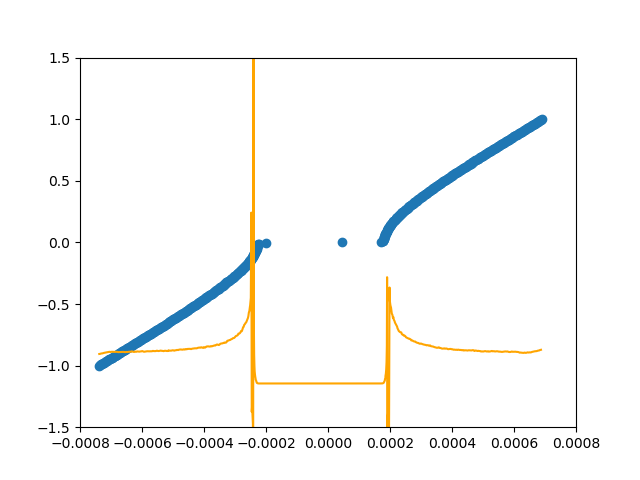

(-0.0008, 0.0008)

In [376]:
dv = qc.load_by_id(314)

i = np.array(dv.get_data("ivvi_dac2"))[:,0] *1e-7
b = np.array(dv.get_values('raw_voltage'))[:,0] *1e-2
#v = np.array(dv.get_values('ivvi_setup_v_measurement'))[:,0]
b_interp = np.linspace(-600e-6,600e-6,num=600)
i_interp = -np.interp(b_interp, np.sort(b), i)

plt.figure('1D test')
plt.scatter(b,i*1e4)
plt.plot(b[1:], 1e-6/savitzky_golay(b[:-1]-b[1:], 51,3)-1.2,color='orange')
#plt.plot(b_interp, i_interp)
plt.ylim([-1.5,1.5])
plt.xlim([-8e-4, 8e-4])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


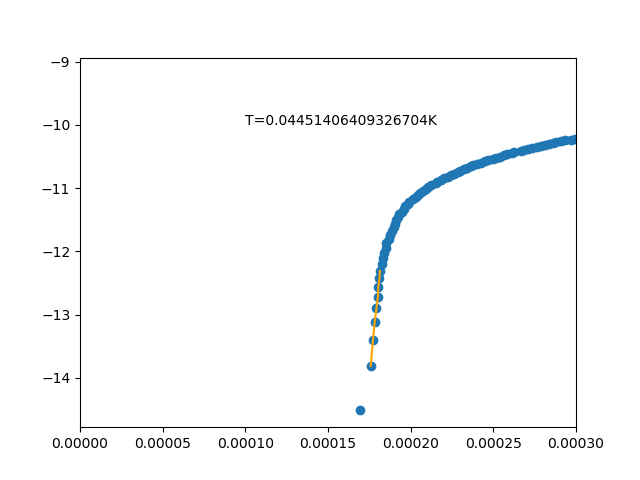

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.0001,-10,'T=0.04451406409326704K')

In [350]:
log_i = np.log(np.abs(i))
plt.figure('log I')
plt.scatter(b, np.log(np.abs(i)))
plt.xlim([0,3e-4])

b_cut = b[np.where(np.logical_and(b>1.7e-4, b<1.82e-4))]
log_i_cut = log_i[np.where(np.logical_and(b>1.7e-4, b<1.82e-4))]
plt.plot(b_cut, log_i_cut,color='orange')

electron_temp_fit_result = np.polyfit(log_i_cut, b_cut, 1)
e_temp = electron_temp_fit_result[0] *1.602e-19/1.38e-23

plt.annotate('T='+str(e_temp)+'K', xy=(1e-4,-10))

0.04451406409326704


In [289]:
R = 15e3 #+ 2*(5e3  + 1.7e3)
b2, i2 = process_data(b_interp, i_interp, R, smooth_win=5) #, v,

plt.figure('after processing')
plt.plot(b2,i2)


ValueError: x and y arrays must be equal in length along interpolation axis.

In [ ]:

b_plus = b2[b2.size//2:]
b_minus = -b2[:b2.size//2]
#v_plus = v2[v2.size//2:]
#v_minus = -v2[:v2.size//2]
i_plus = i2[i2.size//2:]
i_minus = -i2[:i2.size//2]


labels = ['set bias, pos', 'set bias, neg', 'meas. voltage, pos', 'meas. voltage, neg']

fig, axes = plt.subplots(2, 2, figsize=(4, 4), sharex=True, sharey=True)

for i,v, ax, lbl in zip([i_plus, i_minus]*2, [b_plus, b_minus], axes.reshape(-1), labels):
    fitv,fiti, T = fit_linslope(i, v, ilim=(0.003, .03))
    ax.plot(v, i, 'o', ms=2, label=lbl)
    ax.plot(fitv, fiti, '-', label=f'T = {T*1e3:.0f} mK')
    ax.legend(loc='upper left', fontsize='x-small')
    
    ax.set_yscale('log')
    ax.grid(dashes=[2,2])
    ax.set_ylim([10**-3, 10**1])
    
axes[0,0].set_ylabel('Current (nA)')
axes[1,0].set_ylabel('Current (nA)')
axes[1,0].set_xlabel('Bias (uV)')
axes[1,1].set_xlabel('Bias (uV)')

# fig.suptitle(ds_title(dataid), size='x-small')
fig.tight_layout()

In [5]:
def plot1D(data, x, y):
    x_ax = np.unique(np.array(data.get_values(x))) #[::-1]
    #x_ax /= 1e6
    i = np.array(data.get_values(y))
    i = -i[:,0]
    #i = smooth(i, 31, 3)
    #g_sub = curr2cond(i, 20e-6, 16.4e3)
    plt.figure()
    plt.plot(x_ax, i) #, label=x2+' = '+str(x2_value*10)+'mV')
    plt.xlabel(x+' (V)')
    #plt.ylabel('dI/dV (G0)')
    plt.legend()
    return x_ax, i

In [407]:
dat1.get_parameters()

[ivvi_dac1 (numeric),
 raw_voltage (numeric),
 current (numeric),
 leakage_voltage (numeric)]

<IPython.core.display.Javascript object>


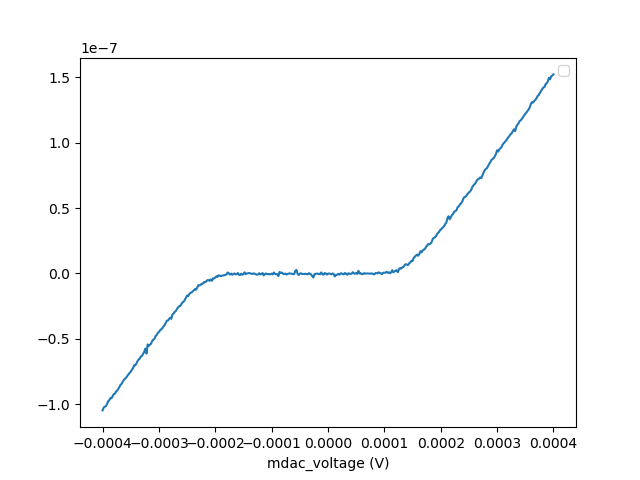

No handles with labels found to put in legend.


In [10]:
dat1 = load_by_id(364)
v_bias,i = plot1D(dat1, "mdac_voltage", "current")   #ivvi_dac1

[61.60552403] [-69.87772254]
[-0.02744403] [-4.13609926]


<IPython.core.display.Javascript object>


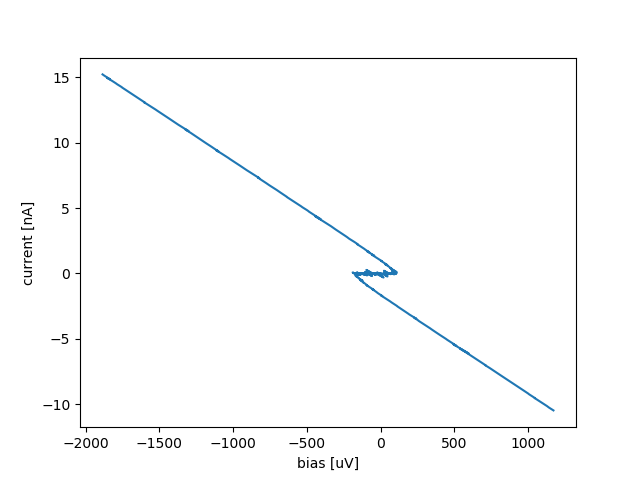

<IPython.core.display.Javascript object>


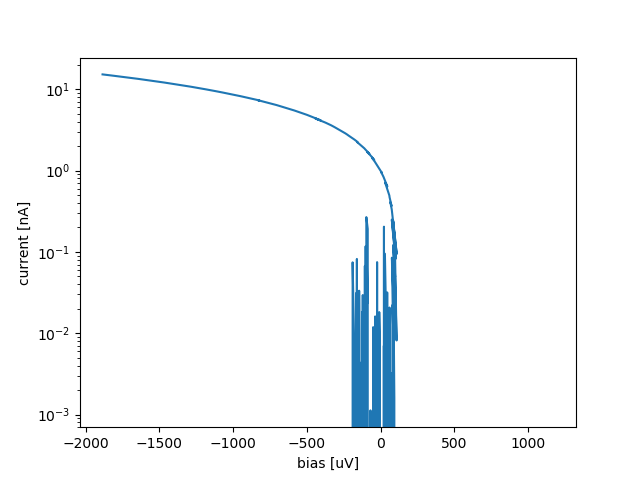

In [11]:
b2, i2 = process_data(v_bias, i, 15e3, smooth_win=10)
plt.figure()
plt.plot(b2,i2)
plt.xlabel("bias [uV]")
plt.ylabel("current [nA]")
plt.figure()
plt.plot(b2,i2)
plt.xlabel("bias [uV]")
plt.ylabel("current [nA]")
plt.yscale('log')

<IPython.core.display.Javascript object>


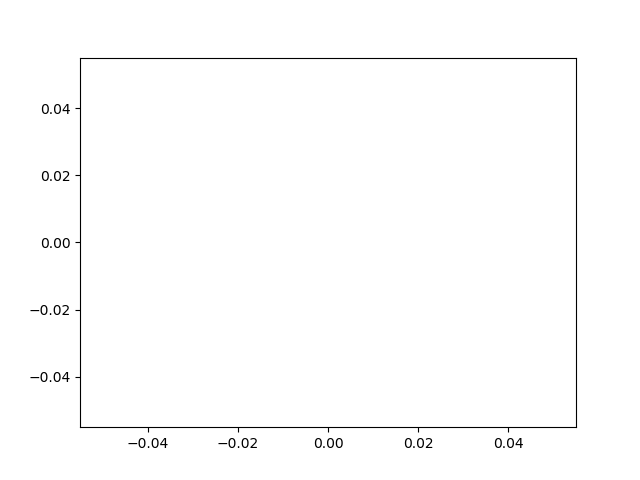

TypeError: expected non-empty vector for x

In [544]:
fitv,fiti, T = fit_linslope(i2, b2, vlim=(160, 175))

In [538]:
T

0.008713812752264011

<IPython.core.display.Javascript object>


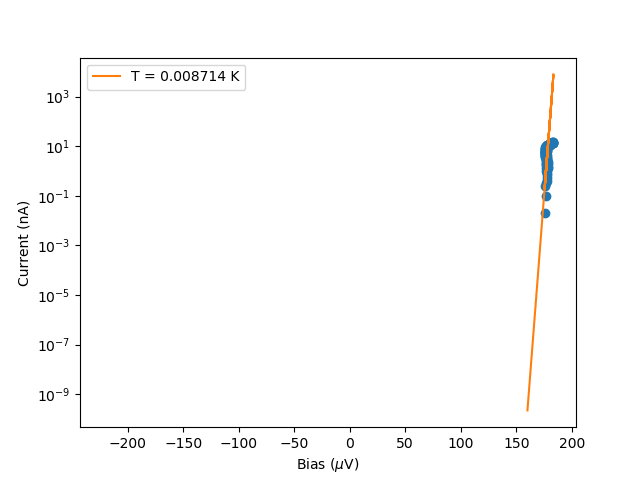

In [539]:
plt.figure()
plt.plot(b2,i2,'o')
plt.plot(fitv,fiti, label='T = '+'{:2f}'.format(T)+' K')
plt.yscale('log')
plt.xlabel('Bias ($\mu$V)')
plt.ylabel('Current (nA)')
plt.legend()

In [11]:
dv = qc.load_by_id(367)
print(dv.parameters)
b = np.array(dv.get_data("mdac_voltage"))[:,0]
di = np.array(dv.get_values('L1X'))[:,0]
di_y = np.array(dv.get_values('L1Y'))[:,0]

mdac_voltage,current,raw_voltage_dc,conductance,L1X,L1Y


<IPython.core.display.Javascript object>


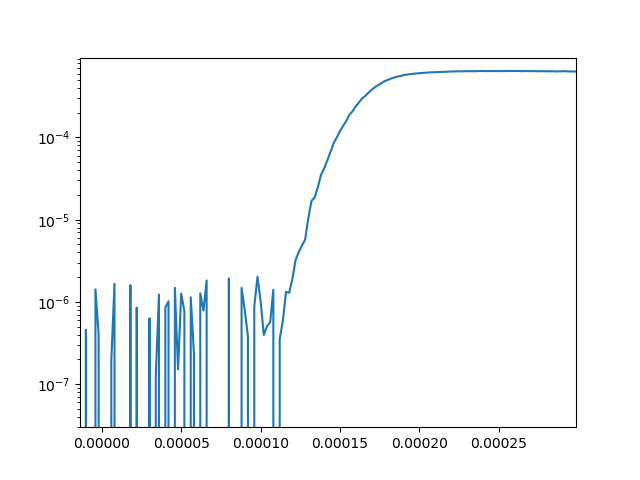

In [16]:
plt.figure('2')
plt.semilogy(b, di)